In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv("APPRAISE_NETFLOW.csv").dropna()

def change_fourth_octet(ip_source):
    parts = ip_source.split('.')
    parts[3] = '0'
    return '.'.join(parts)

df['IPV4_SRC_ADDR'] = df['IPV4_SRC_ADDR'].apply(change_fourth_octet)

In [3]:
# To turn IP into float, take the first octet 89*256^2 + 159*256^1 + 255*256^0
def ip_to_float(ip):
    a, b, c, d = map(int, ip.split('.'))
    return (a << 24) + (b << 16) + (c << 8) + d

df['IPV4_SRC_ADDR'] = df['IPV4_SRC_ADDR'].apply(ip_to_float)
df['IPV4_DST_ADDR'] = df['IPV4_DST_ADDR'].apply(ip_to_float)

In [4]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 7780805 entries, 0 to 7780804
Data columns (total 19 columns):
 #   Column            Dtype  
---  ------            -----  
 0   FLOW_ID           int64  
 1   IPV4_SRC_ADDR     int64  
 2   IPV4_DST_ADDR     int64  
 3   IN_PKTS           int64  
 4   IN_BYTES          int64  
 5   OUT_PKTS          int64  
 6   OUT_BYTES         int64  
 7   FIRST_SWITCHED    int64  
 8   LAST_SWITCHED     float64
 9   L4_SRC_PORT       float64
 10  L4_DST_PORT       float64
 11  TCP_FLAGS         float64
 12  PROTOCOL          float64
 13  PROTOCOL_MAP      object 
 14  TOTAL_FLOWS_EXP   float64
 15  L7_PROTO          float64
 16  L7_PROTO_NAME     object 
 17  ANOMALY_CATEGORY  object 
 18  ANOMALY           float64
dtypes: float64(8), int64(8), object(3)
memory usage: 1.2+ GB


,FLOW_ID,IPV4_SRC_ADDR,IPV4_DST_ADDR,IN_PKTS,IN_BYTES,OUT_PKTS,OUT_BYTES,FIRST_SWITCHED,LAST_SWITCHED,L4_SRC_PORT,L4_DST_PORT,TCP_FLAGS,PROTOCOL,PROTOCOL_MAP,TOTAL_FLOWS_EXP,L7_PROTO,L7_PROTO_NAME,ANOMALY_CATEGORY,ANOMALY
0,1,1503657728,84532874,604,27180,614,29994,1674045983,1.674046e+09,47808.0,47808.0,0.0,17.0,udp,1.0,0.0,Unknown,-,0.0
1,2,3171265792,1343458748,506,23082,510,23424,1674045983,1.674046e+09,502.0,4872.0,24.0,6.0,tcp,2.0,44.0,Modbus,-,0.0
2,3,1352572672,1455332986,24,1704,0,0,1674045983,1.674046e+09,47808.0,47808.0,0.0,17.0,udp,3.0,0.0,Unknown,-,0.0
3,4,1716619776,2267827280,284,23034,284,26004,1674045983,1.674046e+09,61765.0,51807.0,24.0,6.0,tcp,4.0,0.0,Unknown,-,0.0
4,5,1613319936,1052313429,4,160,2,144,1674045983,1.674046e+09,50264.0,3028.0,16.0,6.0,tcp,5.0,0.0,Unknown,-,0.0


In [4]:
df.loc[:,'FLOW_DURATION'] = df['LAST_SWITCHED'] - df['FIRST_SWITCHED']

new_df = df[['FLOW_ID', 'IPV4_SRC_ADDR','IPV4_DST_ADDR','IN_BYTES', 'OUT_BYTES', 'IN_PKTS', 'OUT_PKTS', 'PROTOCOL','L7_PROTO','TCP_FLAGS', 'L4_DST_PORT', 'L4_SRC_PORT']] 

In [7]:
new_df.info()
new_df.head(500)

<class 'pandas.core.frame.DataFrame'>
Index: 7780805 entries, 0 to 7780804
Data columns (total 12 columns):
 #   Column         Dtype  
---  ------         -----  
 0   FLOW_ID        int64  
 1   IPV4_SRC_ADDR  int64  
 2   IPV4_DST_ADDR  int64  
 3   IN_BYTES       int64  
 4   OUT_BYTES      int64  
 5   IN_PKTS        int64  
 6   OUT_PKTS       int64  
 7   PROTOCOL       float64
 8   L7_PROTO       float64
 9   TCP_FLAGS      float64
 10  L4_DST_PORT    float64
 11  L4_SRC_PORT    float64
dtypes: float64(5), int64(7)
memory usage: 771.7 MB


,FLOW_ID,IPV4_SRC_ADDR,IPV4_DST_ADDR,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,PROTOCOL,L7_PROTO,TCP_FLAGS,L4_DST_PORT,L4_SRC_PORT
0,1,1503657728,84532874,27180,29994,604,614,17.0,0.0,0.0,47808.0,47808.0
1,2,3171265792,1343458748,23082,23424,506,510,6.0,44.0,24.0,4872.0,502.0
2,3,1352572672,1455332986,1704,0,24,0,17.0,0.0,0.0,47808.0,47808.0
3,4,1716619776,2267827280,23034,26004,284,284,6.0,0.0,24.0,51807.0,61765.0
4,5,1613319936,1052313429,160,144,4,2,6.0,0.0,16.0,3028.0,50264.0
...,...,...,...,...,...,...,...,...,...,...,...,...
495,451,2287923200,150553450,680,0,10,0,17.0,0.0,0.0,1947.0,56150.0
496,452,3557796352,3334780943,680,0,10,0,17.0,0.0,0.0,1947.0,55189.0
497,453,3557796352,150553450,680,0,10,0,17.0,0.0,0.0,1947.0,55191.0
498,454,3557796352,3334780943,680,0,10,0,17.0,0.0,0.0,1947.0,55192.0


In [5]:
scalar = StandardScaler()
pred_scalar = scalar.fit_transform(new_df)

kmeans = KMeans(n_clusters=5,random_state=42)
cluster_labels = kmeans.fit_predict(pred_scalar)
new_df.loc[:, 'cluster'] = cluster_labels

/tmp/ipykernel_770394/3257806285.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.loc[:, 'cluster'] = cluster_labels


In [8]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(pred_scalar)

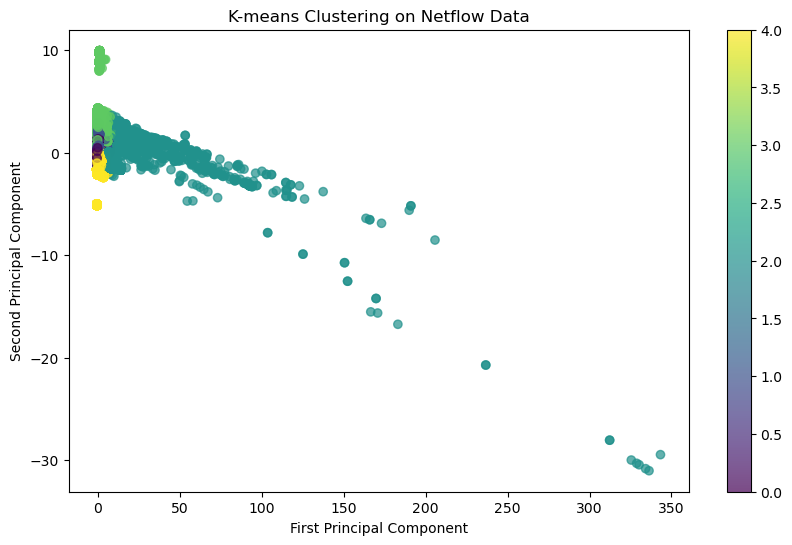

Cluster Centers (scaled):
[[-7.57883035e-02 -3.43250295e-03 -6.63464418e-01 -6.88171185e-02
  -2.72963796e-02 -1.45977829e-01 -1.30393920e-01 -2.01266703e-01
  -3.27353231e-01 -1.74585112e-01 -5.94198368e-01  5.26307236e-01]
 [ 3.56356022e-02 -1.20542015e-01 -4.96167826e-02 -5.61477973e-02
  -2.81303369e-02 -1.41538507e-01 -1.34518378e-01 -4.92852682e-01
  -1.91928336e-01  1.66155711e-02 -2.25272263e-01 -1.63597202e+00]
 [ 4.31150936e-02 -4.44082933e-01 -9.61649913e-02  3.35393154e+00
   1.30645305e+00  7.52503194e+00  7.28740942e+00 -7.57330038e-02
  -2.03440337e-01  4.52457466e-01  9.40006823e-01 -3.11791991e-01]
 [ 2.47953056e-02 -6.86762672e-01  5.75407484e-02 -5.94884260e-02
   1.70788496e-02 -1.45369070e-01 -1.24349214e-01 -6.40516141e-01
   2.51332128e+00  1.45899178e+00 -3.34824686e-01  3.12321053e-01]
 [ 4.65407937e-02  3.23174334e-01  7.00238755e-01 -3.25541148e-02
  -2.16524548e-02 -6.84280116e-02 -8.45418453e-02  7.19469872e-01
  -3.64383129e-01 -3.31411594e-01  8.15386168e

In [9]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('K-means Clustering on Netflow Data')
plt.colorbar(scatter)
plt.show()

# Output: Print cluster centers and some stats
print("Cluster Centers (scaled):")
print(kmeans.cluster_centers_)
# print("\nCluster sizes:")
# print(df['cluster'].value_counts())

In [ ]:
pd.DataFrame(scalar.fit_transform(new_df)).corr()

In [8]:
new_df = df[[
    'FLOW_DURATION', 'IN_PKTS', 
    'PROTOCOL', 'L7_PROTO', 'TCP_FLAGS', 'L4_SRC_PORT'
]]

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(new_df)

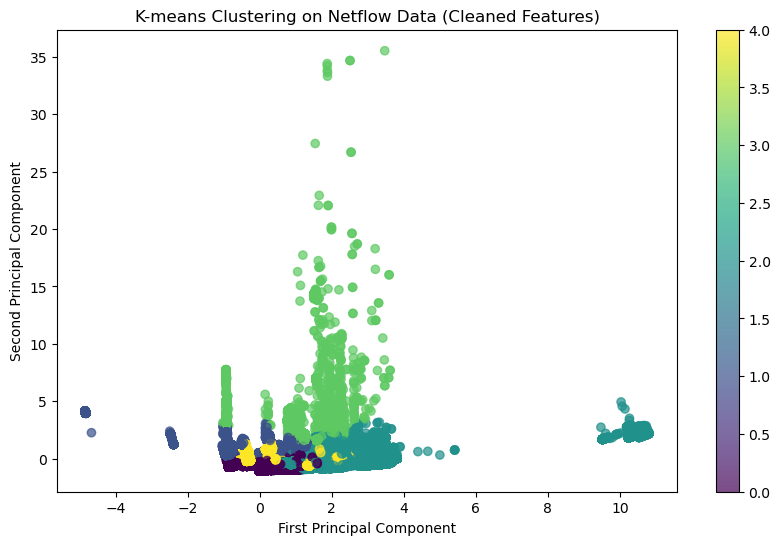

In [9]:
# K-means
kmeans = KMeans(n_clusters=5, random_state=42)
labels = kmeans.fit_predict(X_scaled)
df['cluster'] = labels

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('K-means Clustering on Netflow Data (Cleaned Features)')
plt.colorbar(scatter)
plt.show()

In [ ]:
# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(numeric_cols)

# K-means
kmeans = KMeans(n_clusters=5, random_state=42)
labels = kmeans.fit_predict(X_scaled)
df['cluster'] = labels

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [ ]:

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('K-means Clustering on Netflow Data (Cleaned Features)')
plt.colorbar(scatter)
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(X.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

In [ ]:
pca = PCA()
pca.fit(X_scaled)
print(pca.explained_variance_ratio_)
print("Total variance explained by PC1:", pca.explained_variance_ratio_[0])